# Medical Image Analysis

**Dataset:** 21 medical images (2D) in NIFTI format (filename extension slicexxx.nii.gz) from chest CT scan. Data are encoded in Hounsfield units (HU). Those 2D sections are axial slices of the lungs.
In those images, most of the bright voxels within the lung parenchyma represent vessels (see Figure 1). Most normal lung parenchyma is below –300 HU and above –1000 HU. 

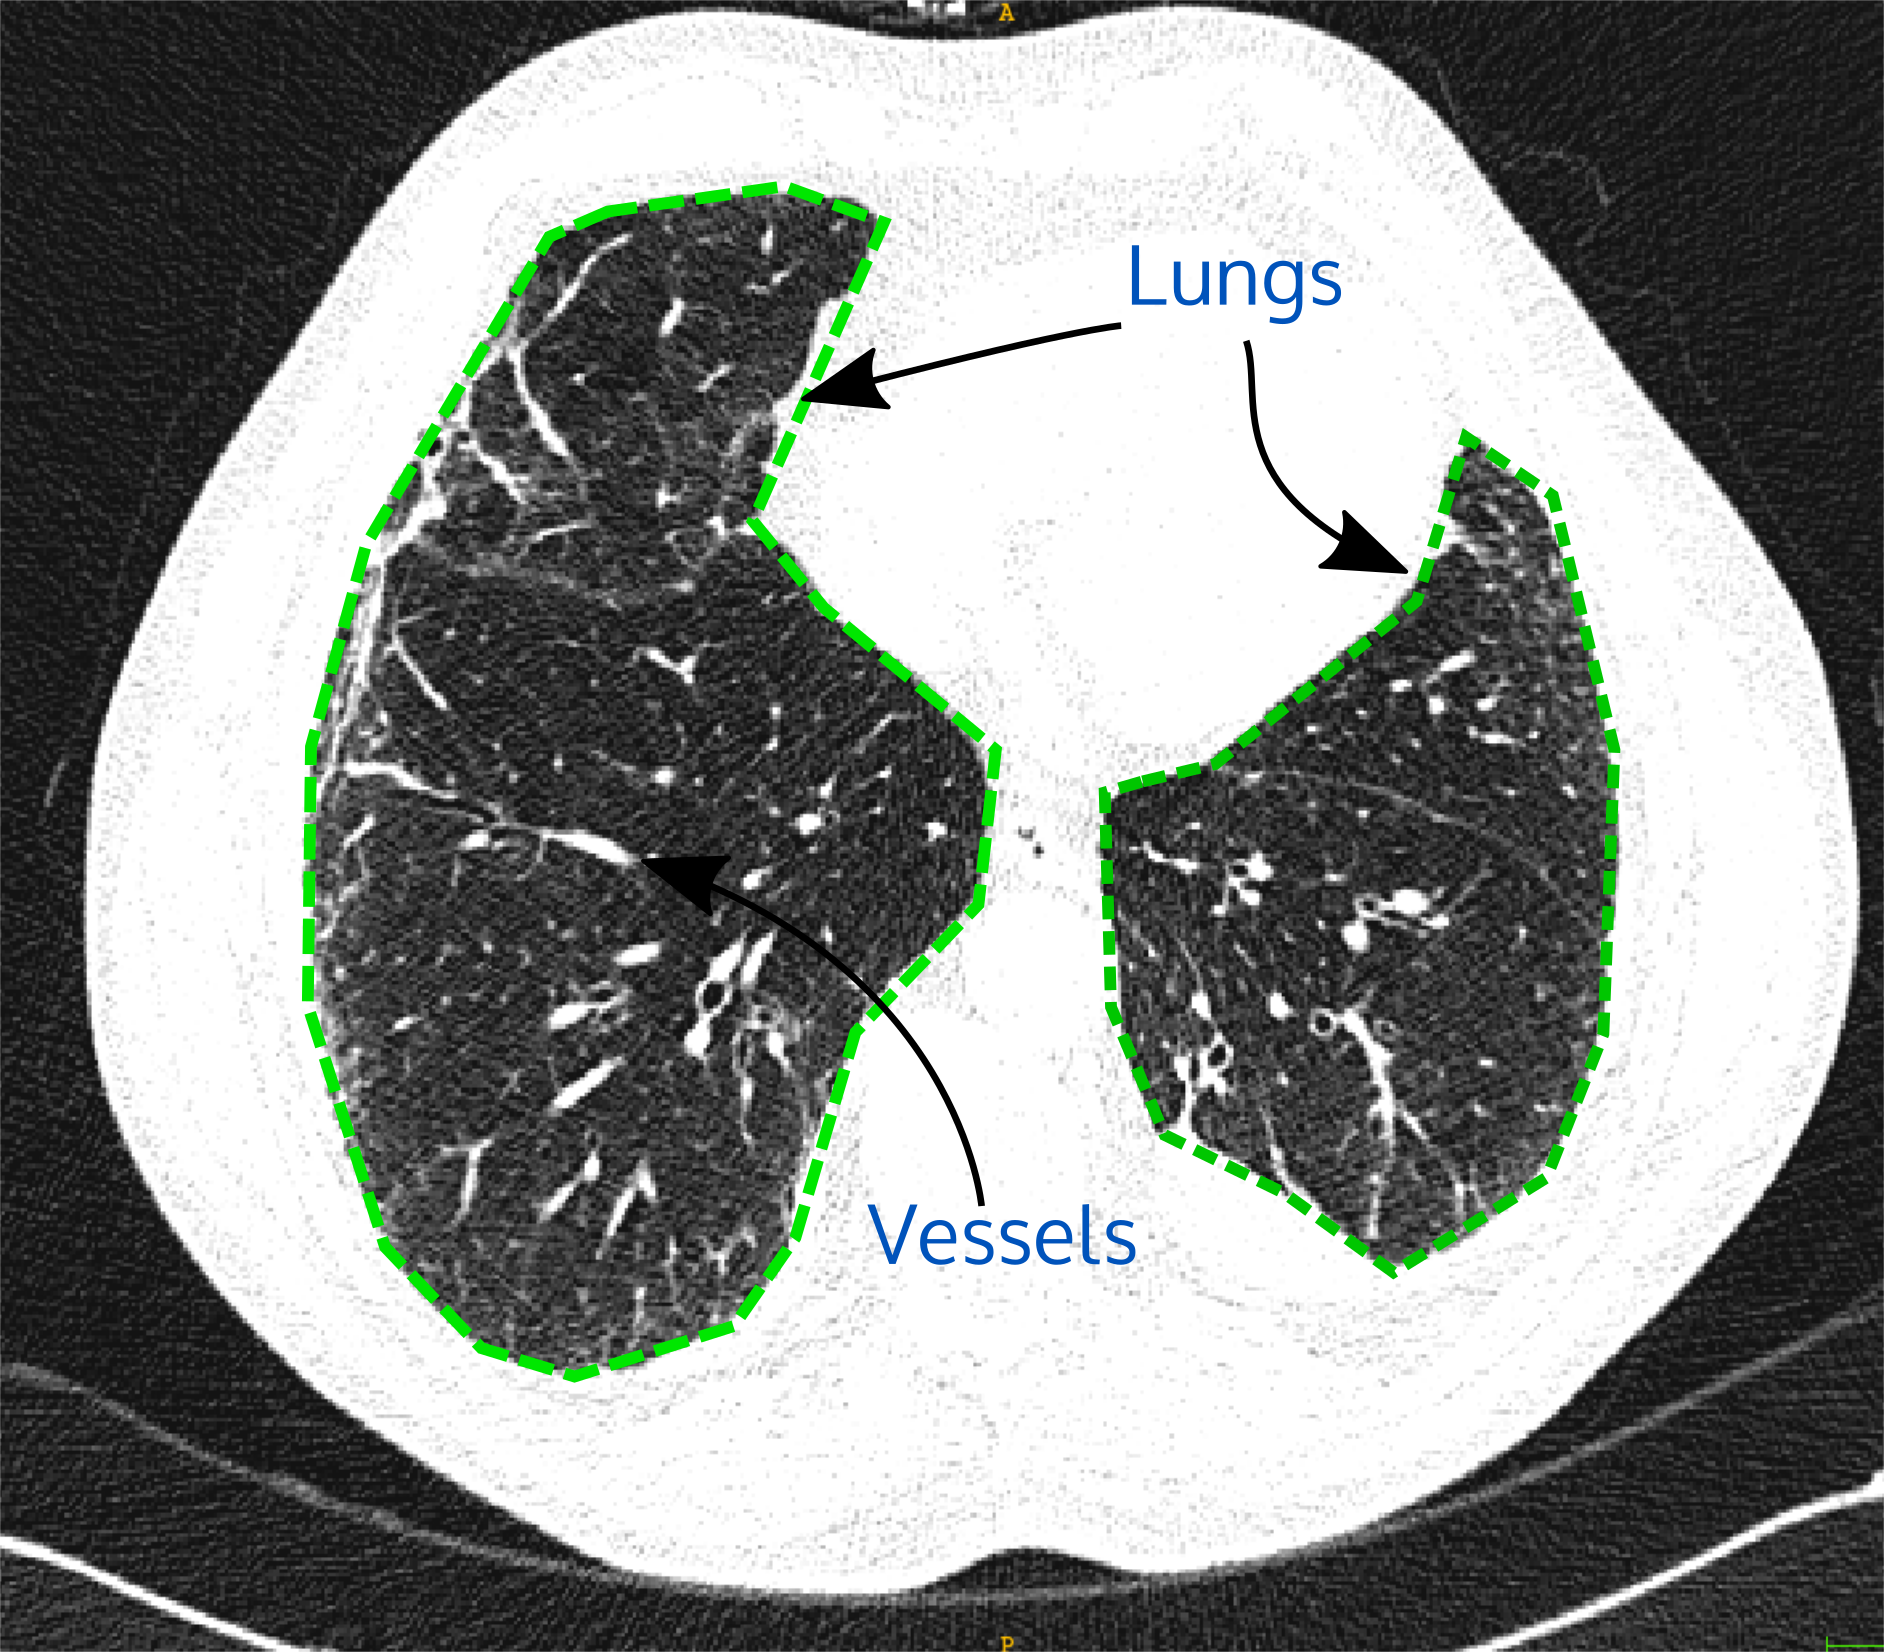

In [10]:
from IPython.display import Image
Image(filename= "image.png", width=300, height=300)

*Figure 1. Example 2D slice image of the chest CT scan with lung outlined in green. Current viewing window settings: level=-600HU and width=1000HU.*

**Tasks:** 
1. For each image, segment the lung in the image (excluding bowels, trachea and other dark regions outside the lung) and compute the lung area in mm². 
2. For each image, segment the main vessels voxels with values higher than -500 HU and compute the relative vessels over lung area in % (vessel-lung area ratio).
3. For the whole dataset, based on the vessel-lung area ratio divide the cases into 2 sub-groups of images based on similar characteristics.

## 1. Importing libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import numpy.ma as ma
import nibabel as nib # working with NIFTI 

## 2. Loading a NIFTI image & exploring image metadata

In [2]:
image = nib.load("slice001.nii.gz")

In [3]:
print(image.header) # image metadata

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  2 512 512   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.677734 0.677734 0.7      1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 175.161
qoffset_y       : 306.661
qoffset_z       : -109.

- dim: size of the image array. We have 2 dimensions and an image size of 512 x 512 pixels.
- pixdim: grid spacings. Dimension for each pixel or voxel. In this case: 0.68 x 0.68.
- xyzt_units: units of measurement for the pixdim field. In this case: 0 (unknown).

## 3. Loading and visualizing images

In [4]:
numbers = ["%.2d" % i for i in range(1,22)]
image = [nib.load(f"slice0{i}.nii.gz") for i in numbers]

In [5]:
img = [image[i].get_fdata() for i in range(0,21)]

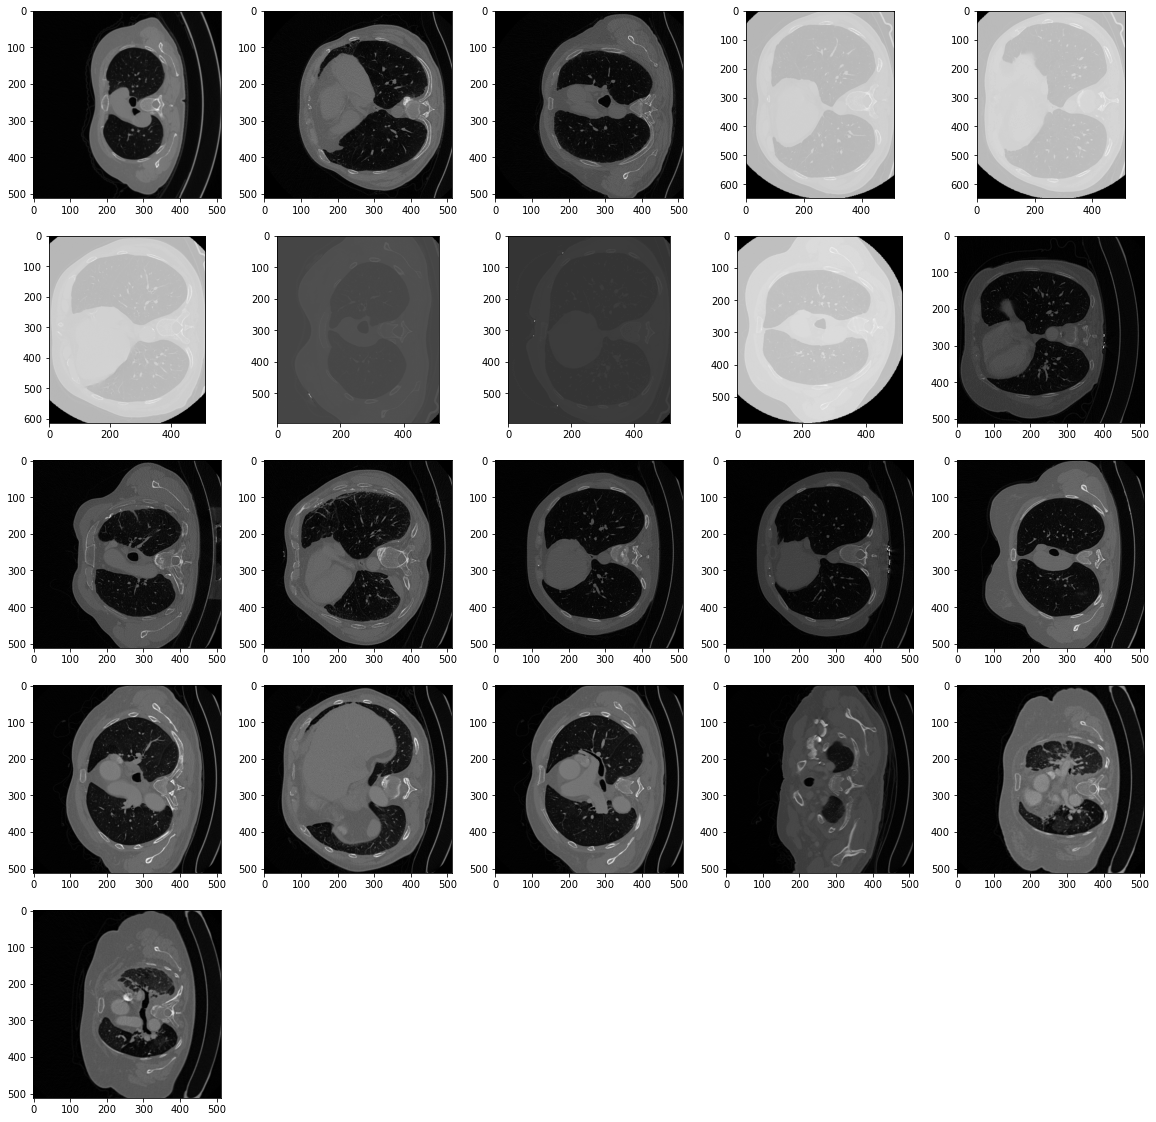

In [6]:
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)):
    plt.subplot(5,5,j), plt.imshow(img[i], cmap="gray") 

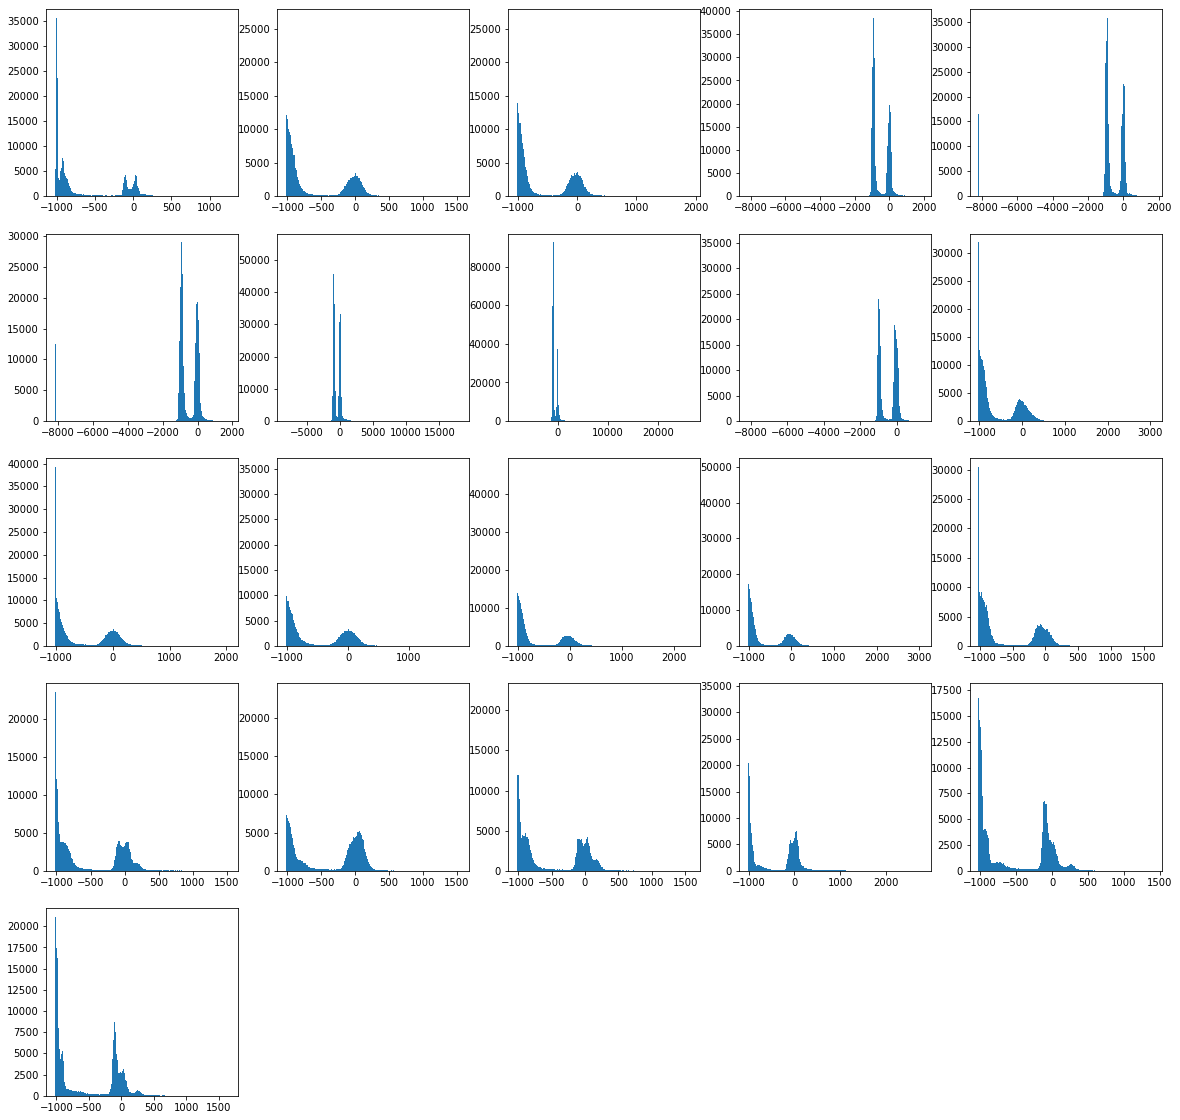

In [7]:
# Pixel intensities:
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)): #ravel returns contiguous flattened array
    plt.subplot(5,5,j), plt.hist(img[i].ravel(), bins=256) 

We can see the two main peaks around -1000 HU (air) and 0 HU (water).

## 4. Image dimension and pixels

In [8]:
dim = []
pix_dim = []
pix_unit = []

for i in range(0, 21):
    dim.append(image[i].header["dim"][1:3])
    pix_dim.append(image[i].header["pixdim"][1:3])
    pix_unit.append(image[i].header["xyzt_units"])

In [9]:
print(dim)

[array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([648, 512], dtype=int16), array([648, 512], dtype=int16), array([615, 512], dtype=int16), array([594, 512], dtype=int16), array([594, 512], dtype=int16), array([581, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16), array([512, 512], dtype=int16)]


In [10]:
print(pix_dim)

[array([0.677734, 0.677734], dtype=float32), array([0.78515625, 0.78515625], dtype=float32), array([0.78515625, 0.78515625], dtype=float32), array([0.53393984, 0.53358597], dtype=float32), array([0.53393984, 0.53358597], dtype=float32), array([0.5543724, 0.5542207], dtype=float32), array([0.48821548, 0.4880703 ], dtype=float32), array([0.48821548, 0.4880703 ], dtype=float32), array([0.6335439 , 0.63399607], dtype=float32), array([0.6425781, 0.6425781], dtype=float32), array([0.6855469, 0.6855469], dtype=float32), array([0.6855469, 0.6855469], dtype=float32), array([0.69921875, 0.69921875], dtype=float32), array([0.69921875, 0.69921875], dtype=float32), array([0.69921875, 0.69921875], dtype=float32), array([0.76171875, 0.76171875], dtype=float32), array([0.76171875, 0.76171875], dtype=float32), array([0.76171875, 0.76171875], dtype=float32), array([0.76171875, 0.76171875], dtype=float32), array([0.7421875, 0.7421875], dtype=float32), array([0.7421875, 0.7421875], dtype=float32)]


In [11]:
print(pix_unit)

[array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8), array(0, dtype=uint8)]


All pixel units are unknown (value 0) but, since the pix_dim values are similar to the ones shown in Akinori Hata et al. (1) where they obtained a pixel size of 0.625 mm and 0.781 mm for a 512 x 512 matrix size, we supposed that the values that we have obtained for pix_dim correspond to mm too.

(1) Akinori Hata et al. Effect of Matrix Size on the Image Quality of Ultra-high-resolution CT of the Lung: Comparison of 512 × 512, 1024 × 1024, and 2048 × 2048. Academic Radiology, Vol 25, No 7, July 2018.

## 5. Lung segmentation 

Most normal lung parenchyma is below –300 HU and above –1000 HU. 

lung_HU = [-1000, -300]

In [12]:
mask_lung=[]
for i in range(0,21):
    mask_lung.append(ma.masked_outside(img[i], -300, -1000))

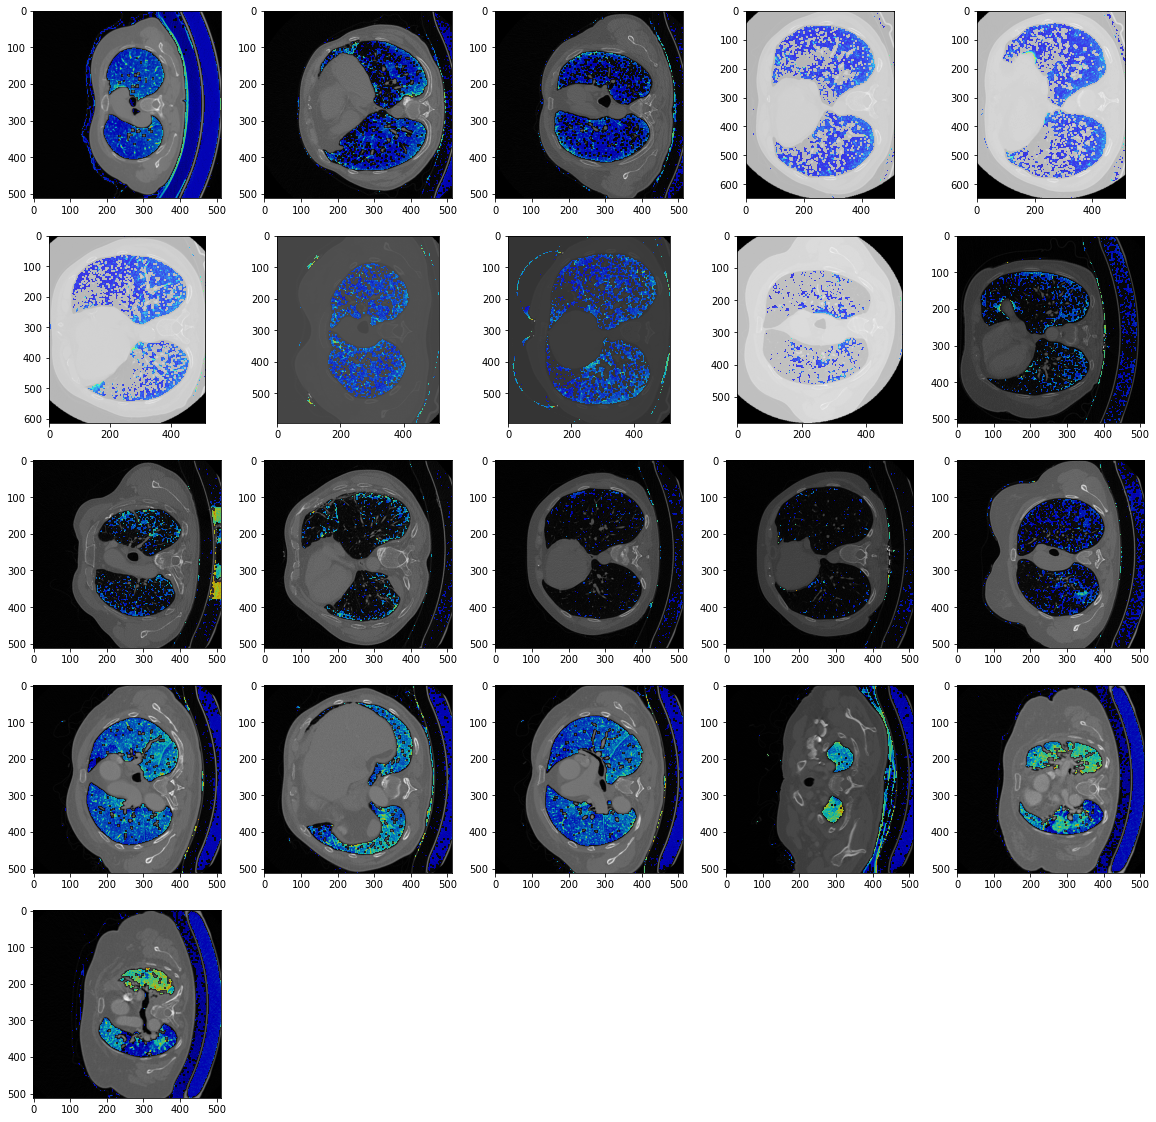

In [13]:
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)):
    plt.subplot(5,5,j), plt.imshow(img[i], cmap="gray")
    plt.imshow(mask_lung[i], cmap="jet", alpha=0.7)

ToDo: We could improve these results by cropping the images, focusing on the lungs.

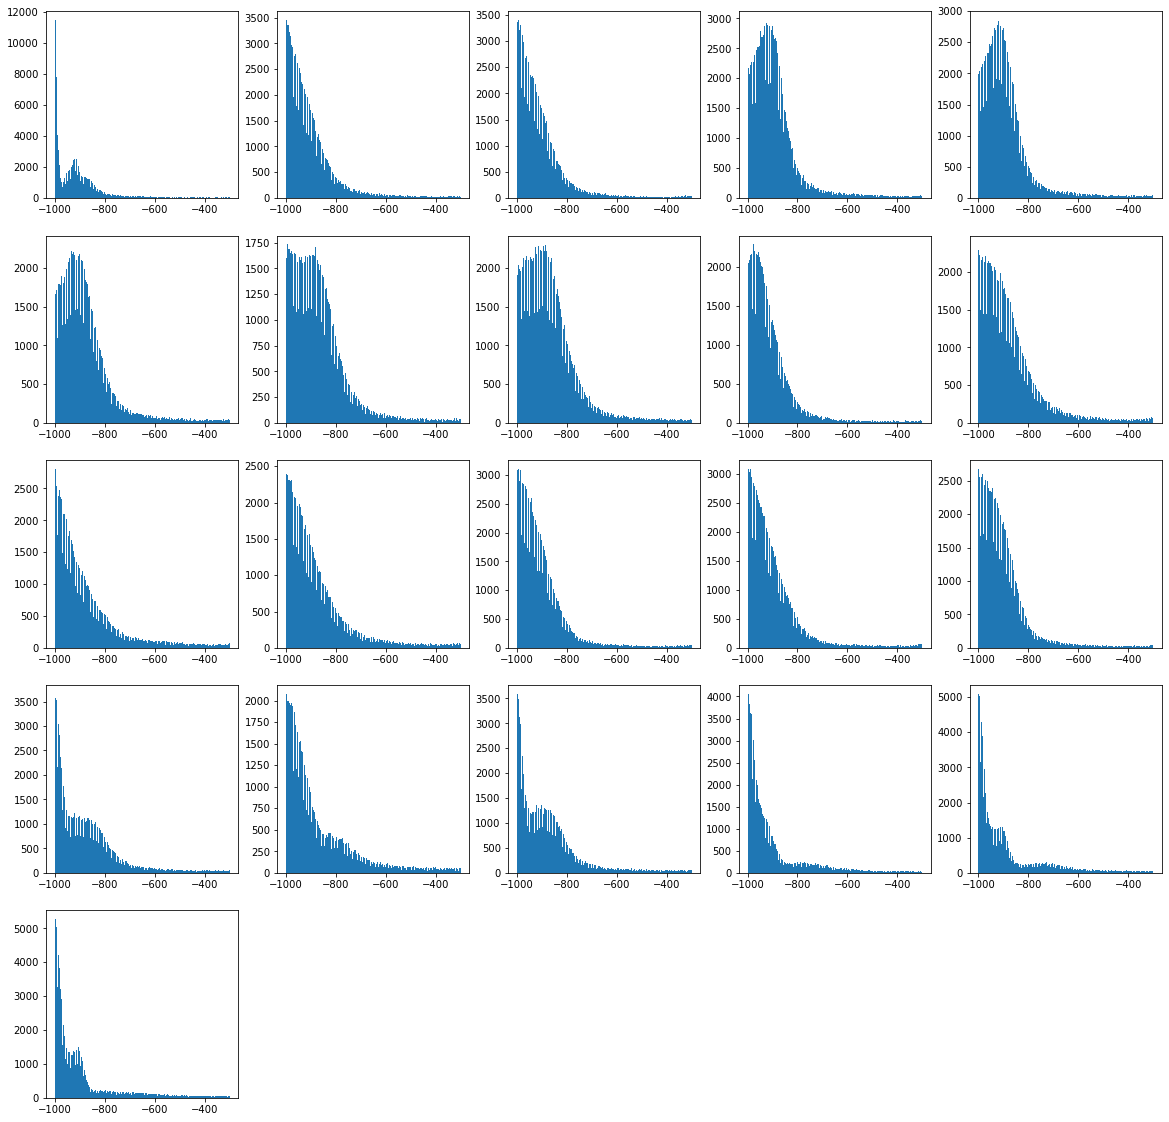

In [14]:
# Pixel intensities: check that are between -300 and -1000
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)):
    plt.subplot(5,5,j), plt.hist(mask_lung[i].ravel(), bins=256)

## 6. Lung area 

Lung area (mm2) = Number of pixels (pix_num) x Dimension-x (mm) of a pixel (pix_dim) x Dimension-y (mm) of a pixel (pix_dim)

In [15]:
pix_num = [] 

for i in range(0, 21):
    pix_num.append(sum(sum(~mask_lung[i].mask))) #number of pixels in the lung
print(pix_num)

[137321, 132501, 130496, 154531, 149444, 133987, 122260, 162016, 96618, 135545, 114295, 117970, 134169, 132798, 124344, 115247, 91607, 116302, 94469, 108095, 109554]


In [16]:
lung_area = [pix_num[i]*pix_dim[i][0]*pix_dim[i][1] for i in range(0,21)]

In [17]:
lung_area = ['%.0f' % elem for elem in lung_area] 
print(lung_area)

['63075', '81683', '80447', '44026', '42577', '41167', '29133', '38606', '38808', '55967', '53716', '55443', '65596', '64926', '60793', '66868', '53152', '67480', '54812', '59543', '60347']


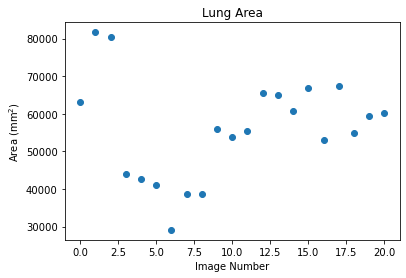

In [18]:
plt.scatter(range(0,21), [int(elem) for elem in lung_area]) #string to integer
plt.title('Lung Area')
plt.xlabel('Image Number')
plt.ylabel('Area (mm$^2$)')
plt.show()

## 7. Main vessels segmentation

Main vessels voxels with values higher than -500 HU

In [19]:
#Vessel > -500, in the lung [-1000, -300]
mask_vessel=[]
for i in range(0,21): 
    mask_vessel.append(ma.masked_outside(img[i], -500, -300)) 

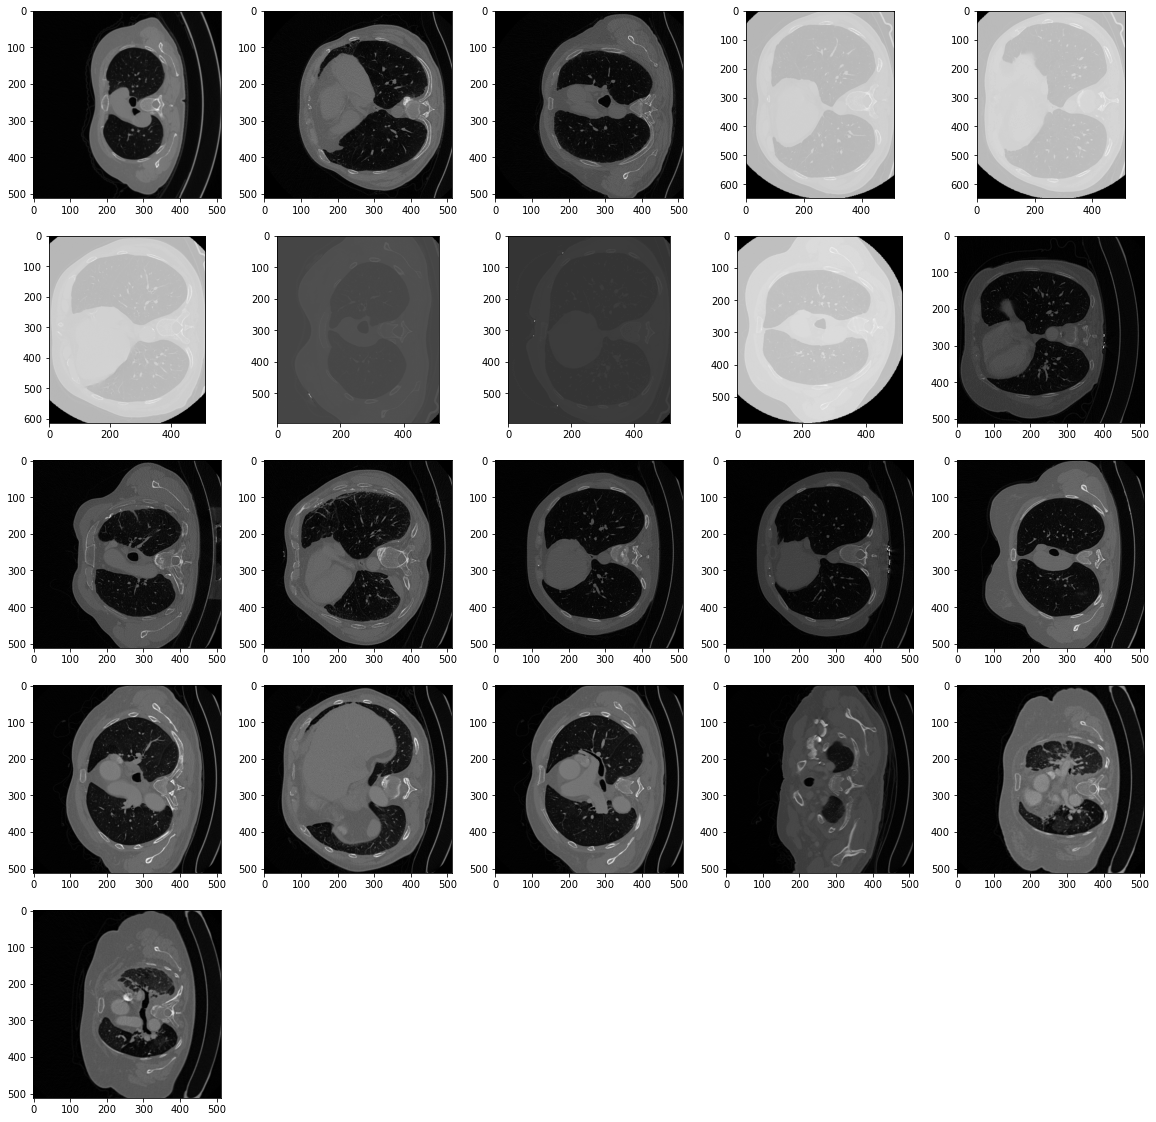

In [20]:
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)):
    plt.subplot(5,5,j), plt.imshow(img[i], cmap="gray") 
    plt.imshow(mask_vessel[i], cmap="jet", alpha=0.7)

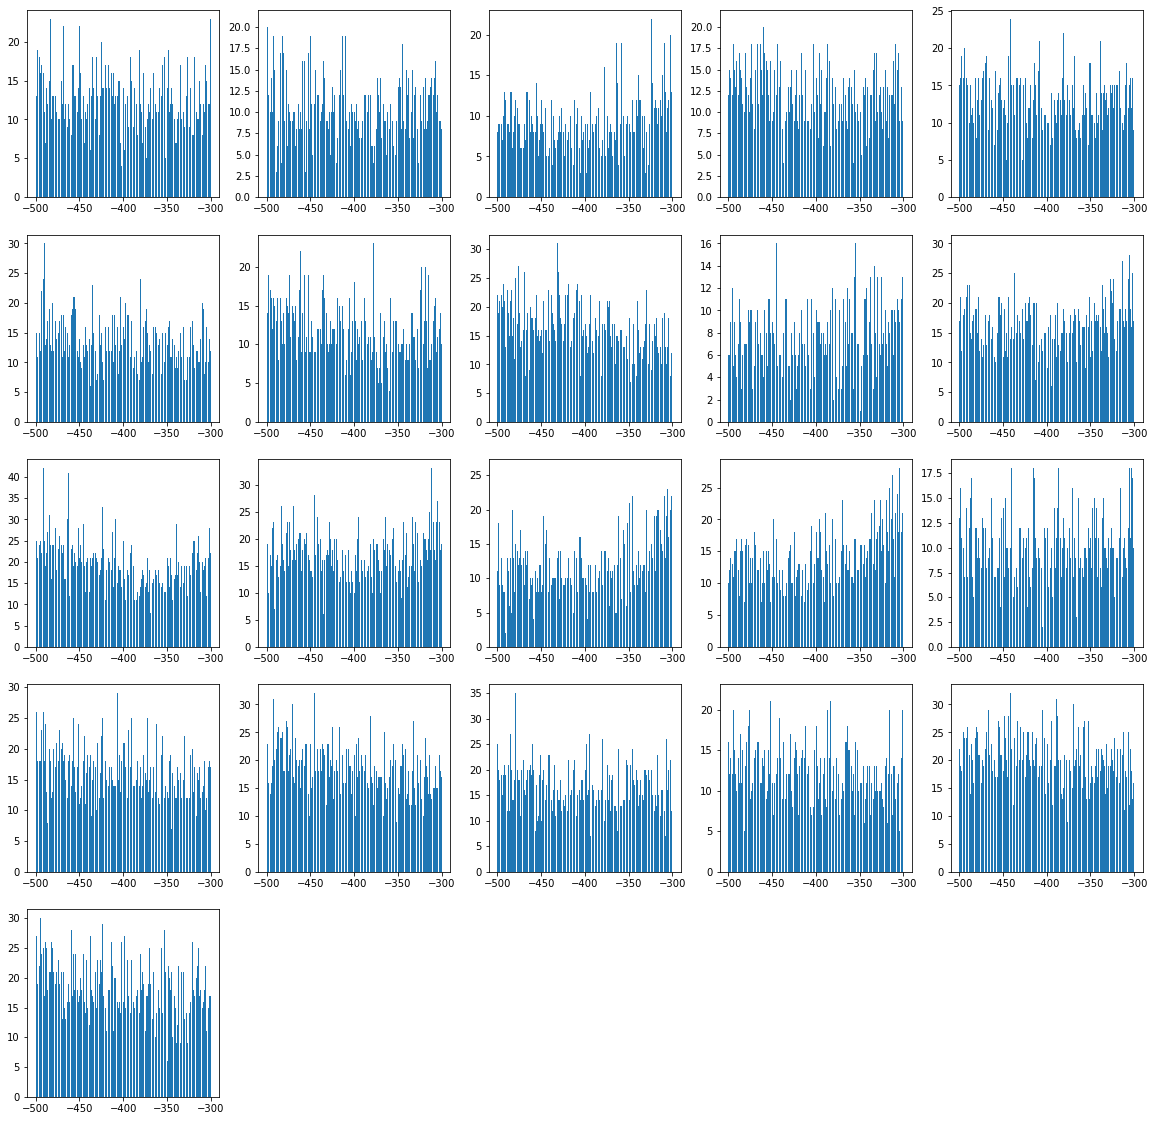

In [21]:
# Pixel intensities:
plt.figure(figsize=(20,20))

for j,i in zip(range(1,22), range(0,21)):
    plt.subplot(5,5,j), plt.hist(mask_vessel[i].ravel(), bins=256) 

Although in the CT-scan images we cannot see the mask overlay, we see that the pixel intensities have been properly selected (from -500 to -300 HU).

## 8. Main vessels area

In [22]:
pixnum_vessel = [] #number of pixels in the vessels

for i in range(0, 21):
    pixnum_vessel.append(sum(sum(~mask_vessel[i].mask))) 
print(pixnum_vessel)

[2550, 2104, 1874, 2448, 2638, 2795, 2361, 3316, 1577, 3397, 3943, 3544, 2421, 2832, 2046, 3222, 3802, 3422, 2500, 4091, 3662]


In [23]:
vessels_area = [pixnum_vessel[i]*pix_dim[i][0]*pix_dim[i][1] for i in range(0,21)]

In [24]:
vessels_area = ['%.0f' % elem for elem in vessels_area] 
print(vessels_area)

['1171', '1297', '1155', '697', '752', '859', '563', '790', '633', '1403', '1853', '1666', '1184', '1385', '1000', '1869', '2206', '1985', '1451', '2253', '2017']


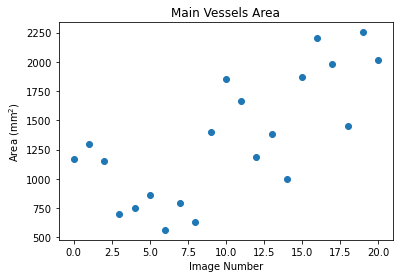

In [25]:
plt.scatter(range(0,21), [int(elem) for elem in vessels_area]) 
plt.title('Main Vessels Area')
plt.xlabel('Image Number')
plt.ylabel('Area (mm$^2$)')
plt.show()

## 9. Vessel-lung area ratio

In [26]:
area_ratio = [100* float(vessels_area[i]) / float(lung_area[i]) for i in range(0,21)]

In [27]:
area_ratio = ['%.2f' % float(elem) for elem in area_ratio] 
print(area_ratio)

['1.86', '1.59', '1.44', '1.58', '1.77', '2.09', '1.93', '2.05', '1.63', '2.51', '3.45', '3.00', '1.80', '2.13', '1.64', '2.80', '4.15', '2.94', '2.65', '3.78', '3.34']


In [28]:
y = np.array([float(elem) for elem in area_ratio])

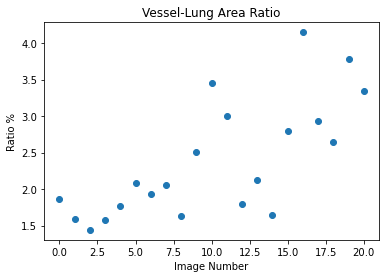

In [29]:
plt.scatter(range(0,21), y) 
plt.title('Vessel-Lung Area Ratio')
plt.xlabel('Image Number')
plt.ylabel('Ratio %')
plt.show()

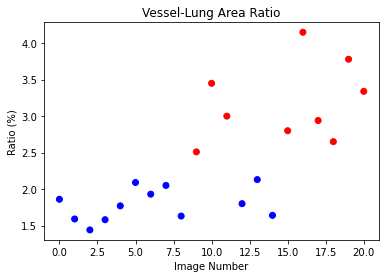

In [30]:
col = np.where(y<2.5,'b','r')

plt.scatter(range(0,21), y, c=col)
plt.title('Vessel-Lung Area Ratio')
plt.xlabel('Image Number')
plt.ylabel('Ratio (%)')
plt.show()

We can divide the whole dataset into 2 sub-groups of images based on similar characteristics: vessel-lung area ratio above and below 2.5% 